# Analyzing Hugging Face PubMed summarization dataset

## Dataset:
- Source: ccdv/pubmed-summarization (https://huggingface.co/datasets/ccdv/pubmed-summarization?row=2)
- Size: 113k
- Columns: article, abstract

Analyzing the dataset to:
- ensure the entries used are good
- explore the number of entries we need to load from the 113k PubMed to make it enoug experiment on long vs. short summarizer vs. recursion architechture


Preprocessing summary:
  - dropna
  - remove the entries with article > 4096 tokesn, abstract > 400 (so that we can compare long text (4k) summarizers and short(1k) summarizers)
  - remove entries with article length too close to abstract (don't fit the concept of abstract), we choose to remove those abstract length of more than it's 1/3 of article length due to the distribution of the data, this way we loose less data but can also ensure the quality



## After data selection
  
  Entries with articles less than 4096 tokens:
  - Split: train: 10700, test: 1125, val: 1107

Entries with articles less than 4096 tokens:
  - Split: train: 10700, test: 1125, val: 1107

** Out of the 113k entries, we chose to only use 24k of it due to limited computing power.



## Content analysis

Lastly we conduct a few analysis with the following metrics:
1. type-token ratio (to show morphological diversity)
2. N-gram novelty (to show abstractiveness)
3. Flesch-Kincaid Grade Level (FKGL) (to evaluate readability)

## Storage
All the datasets and generated summaries can be found in my shared Google Drive folder:
https://drive.google.com/drive/folders/1sNoJxaShjifrt_AqyG5_sZYGxHknqfOM?usp=sharing

---

Use our baseline bart-cnn-large to tokenize scaled down dataset

In [ ]:
scaledown = 20000
article_max_len = 1024
abstract_max_len = 400

folder_name = "bart-pubmed-20k"
huggingface_model = "facebook/bart-large-cnn"

from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.1/266.1 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [ ]:
import wandb
wandb.init(project="FineTune-TextSummarize", name=folder_name)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!pip install datasets
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.4/297.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━

In [ ]:
import torch
import matplotlib.pyplot as plt
from transformers import pipeline
import pandas as pd
from datasets import Dataset, DatasetDict, load_dataset

remove NaN

In [ ]:
dataset = load_dataset("ccdv/pubmed-summarization", download_mode="force_redownload")

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")
print(f"Test dataset size: {len(dataset['validation'])}")

df_train = pd.DataFrame(dataset['train']).dropna()
df_test = pd.DataFrame(dataset['test']).dropna()
df_val = pd.DataFrame(dataset['validation']).dropna()

print('after dropna')
print(f"Train dataset size: {len(df_train)}")
print(f"Test dataset size: {len(df_test)}")
print(f"Test dataset size: {len(df_val)}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for ccdv/pubmed-summarization contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/ccdv/pubmed-summarization
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `d

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Train dataset size: 119924
Test dataset size: 6658
Test dataset size: 6633
after dropna
Train dataset size: 119924
Test dataset size: 6658
Test dataset size: 6633


In [ ]:
# we are only going to study/tokenize a portion of the dataset due to limited computing power
if scaledown:
  df_train = df_train[:scaledown]
  test_val_size = int(scaledown*.1) if int(scaledown*.1) >= 1 else 1
  df_test = df_test[:test_val_size]
  df_val = df_val[:test_val_size]
  print('After scale down to', scaledown, 'with test/val size', test_size)
  print(f"Train dataset size: {len(df_train)}")
  print(f"Test dataset size: {len(df_test)}")
  print(f"Test dataset size: {len(df_val)}")

after scale down to  20000 with test size  2000
Train dataset size: 20000
Test dataset size: 2000
Test dataset size: 2000


In [ ]:
# Convert DataFrames to Hugging Face Datasets
dataset_train = Dataset.from_pandas(df_train)
dataset_test = Dataset.from_pandas(df_test)
dataset_val = Dataset.from_pandas(df_val)

# Create DatasetDict
dataset_dict = DatasetDict({
    'train': dataset_train,
    'test': dataset_test,
    'validation': dataset_val
})

print(dataset_dict)
dataset_med = dataset_dict

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['article', 'abstract'],
        num_rows: 2000
    })
    validation: Dataset({
        features: ['article', 'abstract'],
        num_rows: 2000
    })
})


In [ ]:
dataset_med["train"][:5]

{'article': ["a recent systematic analysis showed that in 2011 , 314 ( 296 - 331 ) million children younger than 5 years were mildly , moderately or severely stunted and 258 ( 240 - 274 ) million were mildly , moderately or severely underweight in the developing countries . \n in iran a study among 752 high school girls in sistan and baluchestan showed prevalence of 16.2% , 8.6% and 1.5% , for underweight , overweight and obesity , respectively . \n the prevalence of malnutrition among elementary school aged children in tehran varied from 6% to 16% . \n anthropometric study of elementary school students in shiraz revealed that 16% of them suffer from malnutrition and low body weight . \n snack should have 300 - 400 kcal energy and could provide 5 - 10 g of protein / day . nowadays , school nutrition programs are running as the national programs , world - wide . national school lunch program in the united states \n there are also some reports regarding school feeding programs in develop

In [ ]:
## Get lengths of train, test and val data
split_train_test_val = [len(dataset_med[split]) for split in dataset_med]
split_train_test_val

[20000, 2000, 2000]

The "article" field contains the full text and the "abstract" the summarized article.

In [ ]:
print(f"Split lengths: {split_train_test_val}")
print(f"Features: {dataset_med['train'].column_names}")
print("\nArticle:")
print(dataset_med["test"][0]["article"])
print("\nAbstract:")
print(dataset_med["test"][0]["abstract"])

Split lengths: [20000, 2000, 2000]
Features: ['article', 'abstract']

Article:
anxiety affects quality of life in those living with parkinson 's disease ( pd ) more so than overall cognitive status , motor deficits , apathy , and depression [ 13 ] . 
 although anxiety and depression are often related and coexist in pd patients , recent research suggests that anxiety rather than depression is the most prominent and prevalent mood disorder in pd [ 5 , 6 ] . yet , 
 our current understanding of anxiety and its impact on cognition in pd , as well as its neural basis and best treatment practices , remains meager and lags far behind that of depression . 
 overall , neuropsychiatric symptoms in pd have been shown to be negatively associated with cognitive performance . 
 for example , higher depression scores have been correlated with lower scores on the mini - mental state exam ( mmse ) [ 8 , 9 ] as well as tests of memory and executive functions ( e.g. , attention ) [ 1014 ] . 
 likewise , 

At first glance (after dropna), it seems like the full 24k dataset is ready to go. But we want to tokenize them to conduct further analysis

# Tokenizing

Here we use our baseline model (pretrained bart-cnn-large without finetuning to tokenize.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Shift all computations to GPU

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = huggingface_model
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

In [ ]:
# Lists of article and abstract lengths in the med dataset after encoding.
d_len = [len(tokenizer.encode(s)) for s in dataset_med["train"]["article"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_med["train"]["abstract"]]

Token indices sequence length is longer than the specified maximum sequence length for this model (5507 > 1024). Running this sequence through the model will result in indexing errors


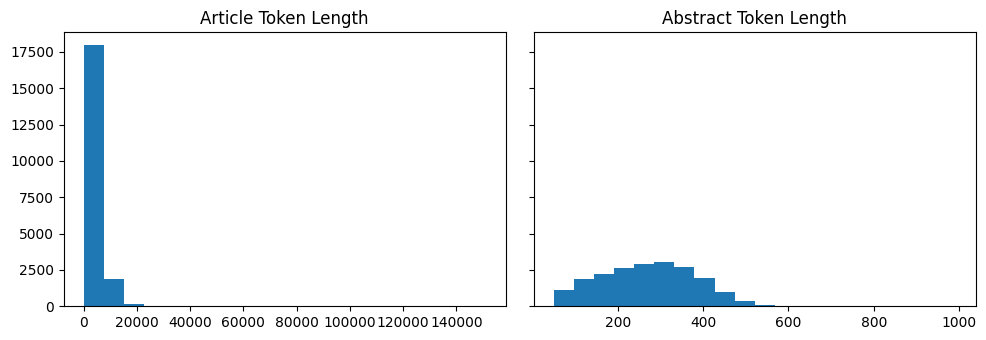

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20)
axes[0].set_title("Article Token Length")
axes[1].hist(s_len, bins=20)
axes[1].set_title("Abstract Token Length")
plt.tight_layout()
plt.show()

# Now tokenize validation and test sets as well

Because we want to remove invalid entries in the next section.

In [ ]:
####
# Validation set
####

# Lists of article and abstract lengths in the med dataset after encoding.
d_len_val = [len(tokenizer.encode(s)) for s in dataset_med["validation"]["article"]]
s_len_val = [len(tokenizer.encode(s)) for s in dataset_med["validation"]["abstract"]]

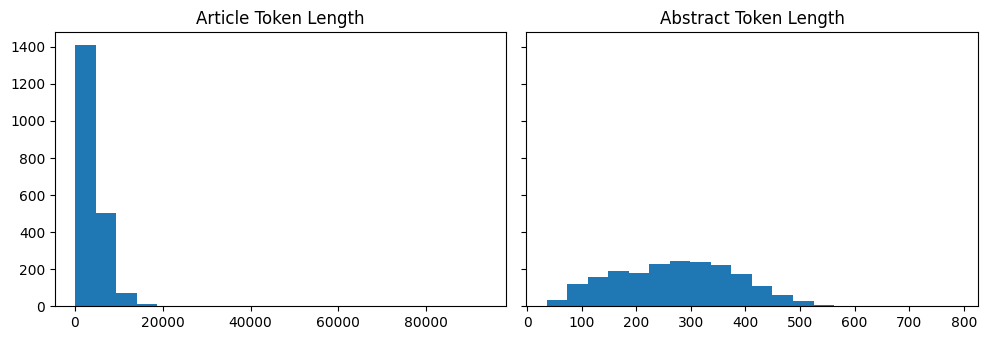

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len_val, bins=20)
axes[0].set_title("Article Token Length")
axes[1].hist(s_len_val, bins=20)
axes[1].set_title("Abstract Token Length")
plt.tight_layout()
plt.show()

In [ ]:
####
# Test set
####

# Lists of article and abstract lengths in the med dataset after encoding.
d_len_test = [len(tokenizer.encode(s)) for s in dataset_med["test"]["article"]]
s_len_test = [len(tokenizer.encode(s)) for s in dataset_med["test"]["abstract"]]

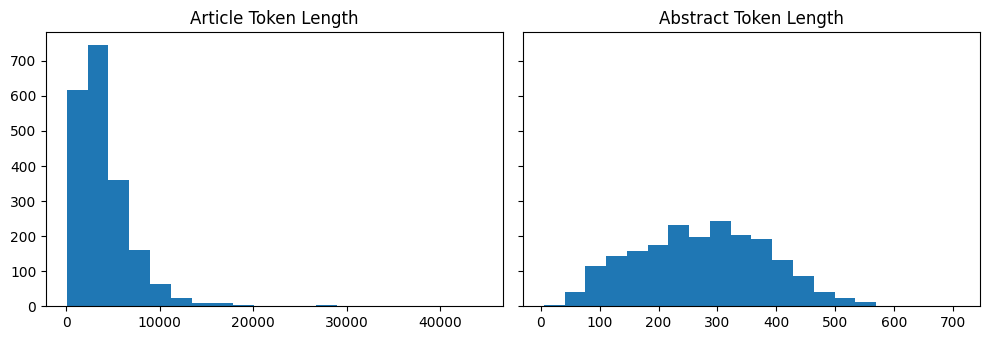

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len_test, bins=20)
axes[0].set_title("Article Token Length")
axes[1].hist(s_len_test, bins=20)
axes[1].set_title("Abstract Token Length")
plt.tight_layout()
plt.show()

With the plots, we are able to see the general distribution of token length for articles and abstracts.

# Data selection
For both train and test
- remove invalid ones (eg. ones with unreasonbly short text, ones where abstract length is too close to the article's length)
- remove ones with artile tokens longer than 4096 for our specific long vs. short summarizer experiment.

In [ ]:
####
# Training set
####

token_df = pd.DataFrame(list(zip(d_len, s_len)), columns =['article_len', 'abstract_len'])
token_df.describe()

,article_len,abstract_len
count,20000.000000,20000.000000
mean,4037.903950,271.296300
std,3523.099609,108.656623
min,2.000000,50.000000
25%,1930.000000,187.000000
50%,3335.000000,273.000000
75%,5192.000000,351.000000
max,150981.000000,992.000000


In [ ]:
# remove the entries
# 1. article token > 4k (because we want to compare the difference between a 4k summarizer and 1k summarizer)
# 2. artickle token < abstract token len * 3 (because we want to make sure no entries with a disporportionate length ratio is in)
# 3. abstract > 400 (to save computing power & since the majority of abstracts are < 400 tokens, we want to set generated text max length smaller to fit our dataset)

og_len = scaledown
token_df = token_df.drop(token_df[token_df['article_len'] > 4096].index)
token_df = token_df.drop(token_df[token_df['article_len'] < token_df['abstract_len']*3].index)
token_df = token_df.drop(token_df[token_df['abstract_len'] > 400].index)

print("The number of valid entries is now: ", len(token_df), "(", 100 - int(100*len(token_df)/og_len), "% )" )
token_df.describe()

The number of valid entries is now:  10700 ( 47 % )


,article_len,abstract_len
count,10700.000000,10700.000000
mean,2337.852991,227.668318
std,920.839126,92.263218
min,224.000000,52.000000
25%,1569.750000,150.000000
50%,2248.000000,227.000000
75%,3109.000000,305.000000
max,4096.000000,400.000000


We also want to separate a group of data where article is at most 1024 token long for comparing performance of short & long summarizers on short texts.

In [ ]:
token1024_df = token_df.drop(token_df[token_df['article_len'] > 1024].index)
print("The number of entries with articles shorter than 1024 tokens is: ", len(token1024_df))
token1024_df.describe()

The number of entries with articles shorter than 1024 tokens is:  642


,article_len,abstract_len
count,642.000000,642.000000
mean,833.685358,139.580997
std,153.618063,53.597423
min,224.000000,53.000000
25%,743.500000,98.250000
50%,868.000000,128.500000
75%,951.000000,173.000000
max,1023.000000,339.000000


Now we repeat the same procedure for validation and test set:

In [ ]:
####
# Validation set
####

token_df_val = pd.DataFrame(list(zip(d_len_val, s_len_val)), columns =['article_len', 'abstract_len'])
token_df_val.describe()

,article_len,abstract_len
count,2000.000000,2000.000000
mean,4028.421500,273.562000
std,3703.601124,109.736421
min,89.000000,36.000000
25%,1995.500000,186.000000
50%,3261.500000,276.000000
75%,5128.250000,353.000000
max,93622.000000,788.000000


In [ ]:
og_len = len(token_df_val)
token_df_val = token_df_val.drop(token_df_val[token_df_val['article_len'] > 4096].index)
token_df_val = token_df_val.drop(token_df_val[token_df_val['article_len'] < token_df_val['abstract_len']*3].index)
token_df_val = token_df_val.drop(token_df_val[token_df_val['abstract_len'] > 400].index)

print("The number of valid entries is now: ", len(token_df_val), "(", 100 - int(100*len(token_df_val)/og_len), "% )" )
token_df_val.describe()

The number of valid entries is now:  1107 ( 45 % )


,article_len,abstract_len
count,1107.000000,1107.000000
mean,2301.277326,226.306233
std,882.753021,90.661000
min,355.000000,36.000000
25%,1544.500000,149.500000
50%,2223.000000,228.000000
75%,3031.500000,302.000000
max,4089.000000,400.000000


In [ ]:
token1024_df_val = token_df_val.drop(token_df_val[token_df_val['article_len'] > 1024].index)
print("The number of entries with articles shorter than 1024 tokens is: ", len(token1024_df_val))
token1024_df_val.describe()

The number of entries with articles shorter than 1024 tokens is:  56


,article_len,abstract_len
count,56.000000,56.000000
mean,846.767857,148.000000
std,157.810703,54.307542
min,355.000000,65.000000
25%,757.750000,105.000000
50%,897.500000,141.000000
75%,979.500000,182.500000
max,1014.000000,326.000000


In [ ]:
####
# Test set
####

token_df_test = pd.DataFrame(list(zip(d_len_test, s_len_test)), columns =['article_len', 'abstract_len'])
token_df_test.describe()

,article_len,abstract_len
count,2000.000000,2000.000000
mean,4061.693500,274.786500
std,3203.056512,111.284918
min,68.000000,5.000000
25%,1981.750000,189.750000
50%,3305.500000,277.000000
75%,5116.000000,356.000000
max,44499.000000,711.000000


In [ ]:
og_len = len(token_df_test)
token_df_test = token_df_test.drop(token_df_test[token_df_test['article_len'] > 4096].index)
token_df_test = token_df_test.drop(token_df_test[token_df_test['article_len'] < token_df_test['abstract_len']*3].index)
token_df_test = token_df_test.drop(token_df_test[token_df_test['abstract_len'] > 400].index)

print("The number of testid entries is now: ", len(token_df_test), "(", 100 - int(100*len(token_df_test)/og_len), "% )" )
token_df_test.describe()

The number of testid entries is now:  1125 ( 44 % )


,article_len,abstract_len
count,1125.000000,1125.000000
mean,2321.511111,228.655111
std,907.849590,91.910670
min,580.000000,5.000000
25%,1564.000000,151.000000
50%,2254.000000,231.000000
75%,3047.000000,306.000000
max,4085.000000,399.000000


In [ ]:
token1024_df_test = token_df_test.drop(token_df_test[token_df_test['article_len'] > 1024].index)
print("The number of entries with articles shorter than 1024 tokens is: ", len(token1024_df_test))
token1024_df_test.describe()

The number of entries with articles shorter than 1024 tokens is:  74


,article_len,abstract_len
count,74.000000,74.000000
mean,873.378378,149.135135
std,124.922738,64.668665
min,580.000000,60.000000
25%,780.000000,96.500000
50%,902.000000,142.000000
75%,979.500000,189.250000
max,1017.000000,320.000000


Now let's create a new selected dataset object from the above preprocessed dataframes
- dataset 4096
  - train, test, val
- dataset 1024
  - train, test, val

In [ ]:
####
# Training set
####

token_df['article'] = ''
token_df['abstract'] = ''
token_df.head()

,article_len,abstract_len,article,abstract
2,1572,207,,
4,1540,222,,
5,3490,273,,
6,2237,259,,
7,3719,361,,


In [ ]:
# Fill the dataframe with the article and abstract text for further study
index_list = token_df.index.values.tolist()

article_list = []
abstract_list = []

for i in index_list:
  article_list.append(dataset_med["train"][i]["article"])
  abstract_list.append(dataset_med["train"][i]["abstract"])

token_df['article'] = article_list
token_df['abstract'] = abstract_list
token_df.head()

,article_len,abstract_len,article,abstract
2,1572,207,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side effe...
4,1540,222,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough ...
5,3490,273,"world - wide , infertility affects 1015% of co...",backgroundmicrornas ( mirnas ) play pivotal ro...
6,2237,259,midwife - led primary delivery care for low -...,objective . \n the objective of this study was...
7,3719,361,diabetes decreases the overall life expectancy...,type 2 diabetes is characterized by insulin re...


In [ ]:
token1024_df['article'] = ''
token1024_df['abstract'] = ''
token1024_df.head()

,article_len,abstract_len,article,abstract
14,801,252,,
53,705,64,,
61,801,257,,
66,965,181,,
123,933,113,,


In [ ]:
# Fill the dataframe with the article and abstract text for further study
index_list = token1024_df.index.values.tolist()

article_list = []
abstract_list = []

for i in index_list:
  article_list.append(dataset_med["train"][i]["article"])
  abstract_list.append(dataset_med["train"][i]["abstract"])

token1024_df['article'] = article_list
token1024_df['abstract'] = abstract_list
token1024_df.head()

,article_len,abstract_len,article,abstract
14,801,252,a review of the literature and an extensive me...,backgrounda review of the literature and an ex...
53,705,64,"nathan , as an oncology fellow , knew well tha...",t cells tell macrophages when to start making ...
61,801,257,temporary henna tattoos or pseudotattoo have b...,temporary henna tattoos or pseudotattoos have ...
66,965,181,a 55 year - old man visited our emergency depa...,we report a redo coronary artery bypass grafti...
123,933,113,the laparoscopic removal of a cervical stump f...,"a 43-year - old , who underwent a subtotal hys..."


Now for test and val sets of 4096 token size:

In [ ]:
####
# Test set
####

token_df_test['article'] = ''
token_df_test['abstract'] = ''

# Fill the dataframe with the article and abstract text for further study
index_list = token_df_test.index.values.tolist()

article_list = []
abstract_list = []

for i in index_list:
  article_list.append(dataset_med["test"][i]["article"])
  abstract_list.append(dataset_med["test"][i]["abstract"])

token_df_test['article'] = article_list
token_df_test['abstract'] = abstract_list
token_df_test.head()

,article_len,abstract_len,article,abstract
0,3820,257,anxiety affects quality of life in those livin...,research on the implications of anxiety in par...
1,3409,125,small non - coding rnas are transcribed into m...,"small non - coding rnas include sirna , mirna ..."
3,1170,187,congenital adrenal hyperplasia ( cah ) refers ...,congenital adrenal hyperplasia is a group of a...
6,2273,346,the family is the cornerstone of human social ...,background : since the family is a social syst...
7,3444,333,development of human societies and industriali...,background and objective : anxiety and depre...


In [ ]:
####
# Test set 1024 token
####

token1024_df_test['article'] = ''
token1024_df_test['abstract'] = ''

# Fill the dataframe with the article and abstract text for further study
index_list = token1024_df_test.index.values.tolist()

article_list = []
abstract_list = []

for i in index_list:
  article_list.append(dataset_med["test"][i]["article"])
  abstract_list.append(dataset_med["test"][i]["abstract"])

token1024_df_test['article'] = article_list
token1024_df_test['abstract'] = abstract_list
token1024_df_test.head()

,article_len,abstract_len,article,abstract
15,676,124,the femoral head often leads to healing compli...,fracture of the femoral neck continues to be a...
38,821,133,tuberculosis ( tb ) is a major health issue in...,tuberculosis ( tb ) is a major health issue in...
56,950,145,gossypiboma ( retained surgical sponge ) descr...,gossypiboma is a term used to describe a forei...
163,830,129,the prevalence of syphilis in the normal popul...,a 30-yr - old man was referred for suspicious ...
207,721,140,"the pylorus , duodenal c - loop , and ileoceca...",most of the ingested foreign bodies pass uneve...


In [ ]:
####
# Val set
####

token1024_df_val['article'] = ''
token1024_df_val['abstract'] = ''

# Fill the dataframe with the article and abstract text for further study
index_list = token1024_df_val.index.values.tolist()

article_list = []
abstract_list = []

for i in index_list:
  article_list.append(dataset_med["validation"][i]["article"])
  abstract_list.append(dataset_med["validation"][i]["abstract"])

token1024_df_val['article'] = article_list
token1024_df_val['abstract'] = abstract_list
token1024_df_val.head()

,article_len,abstract_len,article,abstract
20,579,182,an idiopathic epiretinal membrane ( erm ) usua...,we report a case of recurrent epiretinal membr...
112,427,105,"chronic inflammation can continue , resulting ...",we report a case of central venous stenosis du...
121,996,76,"\n a 24-year - old male x , smoking 24 ciga...",baclofen was initially used for the treatment ...
132,706,84,"ophthalmomyiasis , infestation of the eye with...",a 50-year - old male presented with foreign bo...
158,726,149,osteoma is a slow growing benign lesion which ...,osteoma is a benign osteogenic lesion with a v...


# Store the dataframes

Our you can find the files here: https://drive.google.com/drive/folders/1sNoJxaShjifrt_AqyG5_sZYGxHknqfOM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
token4096_df.to_csv('/content/drive/My Drive/pubmed/analysis_token4096_df.csv')
token1024_df.to_csv('/content/drive/My Drive/pubmed/analysis_token1024_df.csv')

# Turn dataframes into dataset object for finetuning

Now drop token length columns and store the selected dataset for finetuning pretrained models:

In [ ]:
token_df = token_df.drop(columns=['article_len', 'abstract_len'])
token_df_test = token_df_test.drop(columns=['article_len', 'abstract_len'])
token_df_val = token_df_val.drop(columns=['article_len', 'abstract_len'])

token1024_df = token1024_df.drop(columns=['article_len', 'abstract_len'])
token1024_df_test = token1024_df_test.drop(columns=['article_len', 'abstract_len'])
token1024_df_val = token1024_df_val.drop(columns=['article_len', 'abstract_len'])

In [ ]:
# Convert DataFrames to Hugging Face Datasets
dataset_train = Dataset.from_pandas(token_df)
dataset_test = Dataset.from_pandas(token_df_test)
dataset_val = Dataset.from_pandas(token_df_val)

# Create DatasetDict
dataset_dict = DatasetDict({
    'train': dataset_train,
    'test': dataset_test,
    'validation': dataset_val
})

dataset_med = dataset_dict
dataset_med

DatasetDict({
    train: Dataset({
        features: ['article_len', 'abstract_len', 'article', 'abstract', '__index_level_0__'],
        num_rows: 10700
    })
    test: Dataset({
        features: ['article_len', 'abstract_len', 'article', 'abstract', '__index_level_0__'],
        num_rows: 1125
    })
    validation: Dataset({
        features: ['article', 'abstract', '__index_level_0__'],
        num_rows: 1107
    })
})

In [ ]:
# Convert DataFrames to Hugging Face Datasets
dataset1024_train = Dataset.from_pandas(token1024_df)
dataset1024_test = Dataset.from_pandas(token1024_df_test)
dataset1024_val = Dataset.from_pandas(token1024_df_val)

# Create DatasetDict
dataset1024_dict = DatasetDict({
    'train': dataset1024_train,
    'test': dataset1024_test,
    'validation': dataset1024_val
})

dataset1024_med = dataset1024_dict
dataset1024_med

DatasetDict({
    train: Dataset({
        features: ['article', 'abstract', '__index_level_0__'],
        num_rows: 642
    })
    test: Dataset({
        features: ['article', 'abstract', '__index_level_0__'],
        num_rows: 74
    })
    validation: Dataset({
        features: ['article', 'abstract', '__index_level_0__'],
        num_rows: 56
    })
})

# Selected dataset size

In [ ]:
# Get lengths of train, test and val data
split_train_test_val = [len(dataset_med[split]) for split in dataset_med]
split_train_test_val

[10700, 1125, 1107]

In [ ]:
# Get lengths of train, test and val data
split_train_test_val_1024 = [len(dataset1024_med[split]) for split in dataset1024_med]
split_train_test_val_1024

[642, 74, 56]

---

# Content analysis
Now we want to have a general idea of the article and abstract content by getting the following statistics:
1. Count word/sent
2. Type token ratio - morphological diversity
3. N-gram novelty

# Analysis 1. Count word/sent

1-1 Average article length
- words

1-2 Average abstract length
- words

In [ ]:
import re
from collections import Counter

In [ ]:
article_words_len = []
article_unique_word_len = []

abstract_words_len = []
abstract_unique_word_len = []

for idx, row in token4096_df.iterrows():
    # article
    article = row['article'].lower()
    article_re = re.sub("[^\w ]", "", article)
    article_words = article_re.split(" ")

    article_words_len.append(len(article_words))
    article_unique_word_len.append(len(Counter(article_words).keys()))

    # abstract
    abstract = row['abstract'].lower()
    abstract_re = re.sub("[^\w ]", "", abstract)
    abstract_words = abstract_re.split(" ")

    abstract_words_len.append(len(abstract_words))
    abstract_unique_word_len.append(len(Counter(abstract_words).keys()))



In [ ]:
token4096_df['article_words_len'] = article_words_len
token4096_df['article_unique_word_len'] = article_unique_word_len

token4096_df['abstract_words_len'] = abstract_words_len
token4096_df['abstract_unique_word_len'] = abstract_unique_word_len

In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
token4096_df = pd.read_csv('/content/drive/My Drive/pubmed/analysis_token4096_df.csv')
token4096_df.head()

,Unnamed: 0.1,Unnamed: 0,article_len,abstract_len,article,abstract,article_words_len,article_unique_word_len,abstract_words_len,abstract_unique_word_len,article_ttr,abstract_ttr
0,0,2,1572,207,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side effe...,1301,484,164,98,0.372022,0.597561
1,1,4,1540,222,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough ...,1196,444,161,107,0.371237,0.664596
2,2,5,3490,273,"world - wide , infertility affects 1015% of co...",backgroundmicrornas ( mirnas ) play pivotal ro...,2584,534,177,85,0.206656,0.480226
3,3,6,2237,259,midwife - led primary delivery care for low -...,objective . \n the objective of this study was...,1894,469,234,89,0.247624,0.380342
4,4,7,3719,361,diabetes decreases the overall life expectancy...,type 2 diabetes is characterized by insulin re...,3059,600,279,131,0.196143,0.469534


# Calculate Type-token ratio (TTR)

ttr = len(unique_words) / len(document_words)

In [ ]:
token4096_df['article_ttr'] = token4096_df['article_unique_word_len'] / token4096_df['article_words_len']
token4096_df['abstract_ttr'] = token4096_df['abstract_unique_word_len'] / token4096_df['abstract_words_len']

token4096_df.head()

,Unnamed: 0,article_len,abstract_len,article,abstract,article_words_len,article_unique_word_len,abstract_words_len,abstract_unique_word_len,article_ttr,abstract_ttr
0,2,1572,207,"tardive dystonia ( td ) , a rarer side effect ...",tardive dystonia ( td ) is a serious side effe...,1301,484,164,98,0.372022,0.597561
1,4,1540,222,syncope is caused by transient diffuse cerebra...,we present an unusual case of recurrent cough ...,1196,444,161,107,0.371237,0.664596
2,5,3490,273,"world - wide , infertility affects 1015% of co...",backgroundmicrornas ( mirnas ) play pivotal ro...,2584,534,177,85,0.206656,0.480226
3,6,2237,259,midwife - led primary delivery care for low -...,objective . \n the objective of this study was...,1894,469,234,89,0.247624,0.380342
4,7,3719,361,diabetes decreases the overall life expectancy...,type 2 diabetes is characterized by insulin re...,3059,600,279,131,0.196143,0.469534


# Calculate N-gram novelty

To asses the abstractiveness of the datasets. We want to calculate the novelty ratios in terms of ngrams of words (1-grams, 2-grams, and 3-grams).



In [ ]:
###
# ngram for tokens
###

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import string

def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return word_tokenize(text)  # Tokenize into words

def generate_ngrams(text, n):
    words = preprocess_text(text)
    ng = list(ngrams(words, n))
    return ng

def calculate_ngram_novelty_ratio(abstract, full_text, n):
    abstract_ngrams = set(generate_ngrams(abstract, n))
    text_ngrams = set(generate_ngrams(full_text, n))

    novel_ngrams = abstract_ngrams - text_ngrams

    return len(novel_ngrams)/len(abstract_ngrams)

one_gram_novelty, two_gram_novelty, three_gram_novelty = [], [], []

for idx, row in token4096_df.iterrows():

    # calculate n gram novelty
    one_gram_novelty.append(calculate_ngram_novelty_ratio(row['abstract'], row['article'], 1))
    two_gram_novelty.append(calculate_ngram_novelty_ratio(row['abstract'], row['article'], 2))
    three_gram_novelty.append(calculate_ngram_novelty_ratio(row['abstract'], row['article'], 3))

token4096_df['one_gram_novelty'] = one_gram_novelty
token4096_df['two_gram_novelty'] = two_gram_novelty
token4096_df['three_gram_novelty'] = three_gram_novelty

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


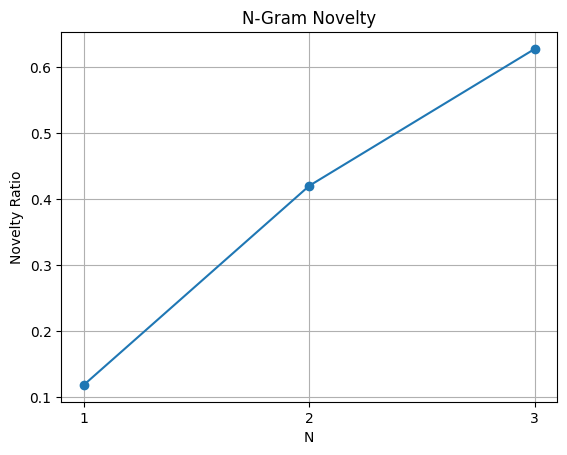

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

novelty_counts = [token4096_df['one_gram_novelty'].mean(), token4096_df['two_gram_novelty'].mean(), token4096_df['three_gram_novelty'].mean()]

# Plot
plt.plot(n_values, novelty_counts, marker='o')
plt.title('N-Gram Novelty')
plt.xlabel('N')
plt.ylabel('Novelty Ratio')
plt.xticks(np.arange(min(n_values), max(n_values)+1, 1))
plt.grid(True)
plt.show()

# Evaluate Readability - Flesch-Kincaid Grade Level (FKGL)

The metric is used to evaluate the training set to make a comparison between the readibility level of machine summarization and human summarization.

In [ ]:
def calculate_flesch_kincaid_grade_level(words, sentences, syllables):
    if words == 0 or sentences == 0:
        return 0
    return 0.39 * (words / sentences) + 11.8 * (syllables / words) - 15.59

def count_syllables(word):
    vowels = "aeiouy"
    count = 0
    word = word.lower().strip(".:;?!")
    if len(word) == 0:
        return 0
    if word[0] in vowels:
        count += 1
    for index in range(1, len(word)):
        if word[index] in vowels and word[index - 1] not in vowels:
            count += 1
    if word.endswith("e"):
        count -= 1
    if count == 0:
        count += 1
    return count

def fkgl(text):
    # Splitting the text into words, sentences, and counting syllables
    words = text.split()
    sentences = text.count('.') + text.count('?') + text.count('!')
    syllables = sum(count_syllables(word) for word in words)

    # Calculating Flesch-Kincaid Grade Level
    flesch_kincaid_grade_level = calculate_flesch_kincaid_grade_level(len(words), sentences, syllables)
    return flesch_kincaid_grade_level

art_FKGL, abs_FKGL = [], []

for idx, row in token4096_df.iterrows():
    art_FKGL.append(fkgl(row['article']))
    abs_FKGL.append(fkgl(row['abstract']))

token4096_df['art_FKGL'] = art_FKGL
token4096_df['abs_FKGL'] = abs_FKGL

In [ ]:
token4096_df['art_FKGL'].mean()

13.459856777726829

In [ ]:
token4096_df['abs_FKGL'].mean()

13.75717637648744

# Store the analysis result

In [ ]:
token4096_df.to_csv('/content/drive/My Drive/pubmed/analysis_token4096_df.csv')